In [2]:
import networkx as nx
import pulp

# Data

In [353]:
# create graph
G = nx.DiGraph()
G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(1,4)
G.add_edge(1,8)
G.add_edge(2,6)
G.add_edge(2,8)
G.add_edge(3,3)
G.add_edge(3,8)
G.add_edge(3,9)
G.add_edge(4,3)
G.add_edge(4,4)
G.add_edge(4,6)
G.add_edge(4,7)
G.add_edge(5,9)
G.add_edge(6,5)
G.add_edge(6,10)
G.add_edge(7,1)
G.add_edge(7,5)
G.add_edge(8,3)
G.add_edge(8,10)
G.add_edge(9,1)
G.add_edge(9,7)
G.add_edge(9,10)

# create line graph
H = nx.line_graph(G)
new_edges = []
# add source and sink nodes
for (u,v) in H.nodes():
    if u==0:
        new_edges.append((("s","s"),(u,v)))
    if v==10:
        new_edges.append(((u,v),("t","t")))
H.add_edges_from(new_edges)

# max number of arcs
M = 5

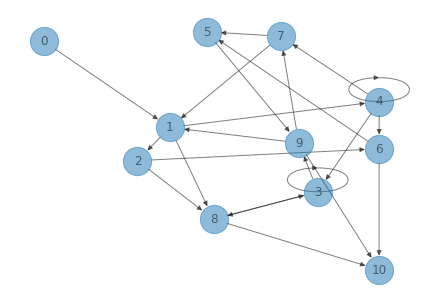

In [345]:
nx.draw(G,pos=nx.spring_layout(G),with_labels=True,node_size=800,alpha=0.5)

In [314]:
nx.shortest_path(G,source=0,target=10)

[0, 1, 8, 10]

In [315]:
nx.shortest_path(H,source=("s","s"),target=("t","t"))

[('s', 's'), (0, 1), (1, 8), (8, 10), ('t', 't')]

# MIP

In [354]:
# create LP
prob = pulp.LpProblem("AllPaths", pulp.LpMinimize)

# x[(i,j)] = 1 if (i,j) is used
x = pulp.LpVariable.dicts("x",
                          H.edges(),
                          cat=pulp.LpBinary)

# objective function : minimize number of edges
prob += pulp.lpSum(x)

# flow conservation
for (u, v) in H.nodes():
    if (u, v) not in [("s", "s"), ("t", "t")]:
        inflow = pulp.lpSum(x[((a, b), (u, v))]
                            for (a, b) in H.predecessors((u, v)))
        outflow = pulp.lpSum(x[((u, v), (a, b))]
                             for (a, b) in H.successors((u, v)))
        prob += inflow == outflow
prob += pulp.lpSum(x[(("s", "s"), (a, b))]
                   for (a, b) in H.successors(("s", "s"))) == 1
prob += pulp.lpSum(x[((a, b), ("t", "t"))]
                   for (a, b) in H.predecessors(("t", "t"))) == 1

# max arcs
prob += pulp.lpSum(x) <= M+2

In [355]:
# solve and add no good cuts
k = 0
while True:
    # solve MIP
    prob.solve()#pulp.CPLEX_CMD())

    # if optimal solution is found, print the edges of the path
    if pulp.LpStatus[prob.status] == "Optimal":
        k += 1
        P = nx.DiGraph()
        for ((u, v), (a, b)) in H.edges():
            if pulp.value(x[((u, v), (a, b))]) > 0.9:
                P.add_edge((u, v), (a, b))
        # print(k, i, nx.shortest_path(P, ("s", "s"), ("t", "t")))
        # add no good cut
        yes_vars = pulp.lpSum((1-x[((u, v), (a, b))])
                              for ((u, v), (a, b)) in P.edges())
        no_vars = pulp.lpSum(x[((u, v), (a, b))] for (
            (u, v), (a, b)) in H.edges() if ((u, v), (a, b)) not in P.edges())
        prob += yes_vars >= 1  
        prob += no_vars >= 2
    else:
        break
print(k, "paths")

21 paths


# Ranking paths

In [285]:
from itertools import islice

In [351]:
# create line graph
H = nx.line_graph(G)
new_edges = []
# add source and sink nodes
for (u,v) in H.nodes():
    if u==0:
        new_edges.append(("source",(u,v)))
    if v==10:
        new_edges.append(((u,v),"sink"))
H.add_edges_from(new_edges)

In [352]:
# 9 shortest paths
list(islice(nx.shortest_simple_paths(H, source="source", target="sink"), 9))

[['source', (0, 1), (1, 8), (8, 10), 'sink'],
 ['source', (0, 1), (1, 2), (2, 8), (8, 10), 'sink'],
 ['source', (0, 1), (1, 4), (4, 6), (6, 10), 'sink'],
 ['source', (0, 1), (1, 2), (2, 6), (6, 10), 'sink'],
 ['source', (0, 1), (1, 8), (8, 3), (3, 8), (8, 10), 'sink'],
 ['source', (0, 1), (1, 4), (4, 3), (3, 8), (8, 10), 'sink'],
 ['source', (0, 1), (1, 8), (8, 3), (3, 9), (9, 10), 'sink'],
 ['source', (0, 1), (1, 4), (4, 4), (4, 6), (6, 10), 'sink'],
 ['source', (0, 1), (1, 4), (4, 3), (3, 9), (9, 10), 'sink']]

In [307]:
M=10
count=0
for p in list(islice(nx.shortest_simple_paths(H, source="source", target="sink"), 300)):
    if len(p)<=M+3:
        count+=1
print(count)

268
